<a href="https://colab.research.google.com/github/nyny137/cynthia/blob/main/Influence_Analysis_in_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install, import and options

In [1]:
!pip install adjustText --quiet
!pip install scikit-network --quiet
!pip install selenium --quiet
!apt-get update --quiet
!apt install chromium-chromedriver --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubun

In [2]:
from adjustText import adjust_text
from bs4 import BeautifulSoup
import datetime
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
from selenium import webdriver
from sklearn.linear_model import LinearRegression
from sknetwork.data import from_edge_list
from sknetwork.ranking import PageRank
from sknetwork.visualization import visualize_graph
from statsmodels.distributions.empirical_distribution import ECDF
import time
from tqdm import tqdm

In [3]:
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_columns", 200)

# Utils

In [4]:
def get_driver(url=None):
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.headless = True
    driver = webdriver.Chrome(options=chrome_options)
    if url is not None:
        driver.get(url)
    return driver


def scroll(driver, time_limit=60*5):
    start_time = time.time()
    last_height = driver.execute_script("return document.body.scrollHeight")
    end_of_page_reached, time_limit_reached = False, False
    while not end_of_page_reached and not time_limit_reached:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        new_height = driver.execute_script("return document.body.scrollHeight")
        end_of_page_reached = new_height == last_height
        time_limit_reached = (time.time() - start_time) >= time_limit
        last_height = new_height
    return driver, end_of_page_reached, time_limit_reached


def get_username(url):
    pattern = "/@([^?]+)\?|@([^?]+)|https://([^?]+).medium.com"
    re_search = re.search(pattern, url)
    if re_search:
        return re_search.group(1) or re_search.group(2) or re_search.group(3)


def get_daily_articles(publication_name, date):
    out = []
    driver = get_driver(url = f"https://{publication_name}.com/archive/{date.strftime('%Y/%m/%d')}")
    soup = BeautifulSoup(driver.page_source,"lxml")
    articles = soup.find_all("div", class_="postArticle")
    for article in articles:
        show_recommends_element = article.find('button', {"data-action": "show-recommends"})
        article_url_raw = article.find("a", {"data-action": "open-post"})["href"]
        article_url = article_url_raw.split("?")[0]
        article_claps = show_recommends_element.text if show_recommends_element else float("NaN")
        author_url_raw = article.find("a", {"data-action": "show-user-card"})["href"]
        author_username = get_username(author_url_raw)
        out.append({
            "article_date": date.strftime("%Y-%m-%d"),
            "article_url": article_url,
            "article_claps": article_claps,
            "author_username": author_username,
            "author_name": article.find("a", {"data-action": "show-user-card"}).contents[0].attrs["alt"].split("Go to the profile of ")[1]
        })
    driver.quit()
    return pd.DataFrame(out)


def get_follower_number(username):
    driver = get_driver(url=f"https://medium.com/@{username}/followers")
    soup = BeautifulSoup(driver.page_source,"lxml")
    h2_tags = soup.find_all('h2')
    for tag in h2_tags:
        text = tag.get_text(strip=True)
        if "Followers" in text:
            follower_number = int(text.split(" Followers")[0].replace(",",""))
            driver.quit()
            return follower_number


def get_followed_authors(username):
    driver = get_driver(url=f"https://medium.com/@{username}/following")
    driver, end_of_page_reached, time_limit_reached = scroll(driver)
    soup = BeautifulSoup(driver.page_source,"lxml")
    links = soup.find_all("a", href=lambda x: x and "source=user_following_list" in x)
    usernames_verbose = list(set([link["href"] for link in links]))
    usernames = [get_username(_) for _ in usernames_verbose]
    usernames = [u for u in usernames if u is not None and u != username]
    driver.quit()
    return usernames

# Read data

In [5]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
start_date_str = "2023-01-01"
end_date_str = datetime.datetime.today().strftime("%Y-%m-%d")
articles_path = "/content/drive/MyDrive/Datasets/articles.csv"
authors_path = "/content/drive/MyDrive/Datasets/authors.xlsx"

In [8]:
if "articles" in locals():
    pass
elif os.path.isfile(articles_path):
    articles = pd.read_csv(articles_path, sep="\t", dtype=object)
else:
    articles = pd.DataFrame(columns=["article_date", "article_url", "article_claps", "author_username", "author_name"])

start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end_date_str, "%Y-%m-%d")
num_days = (end_date - start_date).days + 1

for add_days in tqdm(range(num_days)):
    current_date = start_date + datetime.timedelta(days=add_days)
    current_date_str = current_date.strftime("%Y-%m-%d")

    if current_date_str not in articles["article_date"].unique():
        daily_articles = get_daily_articles(publication_name="towardsdatascience", date=current_date)
        articles = pd.concat([articles, daily_articles]).reset_index(drop=True)

articles.to_csv(articles_path, sep="\t", index=False)

  0%|          | 2/627 [00:51<4:30:39, 25.98s/it]


KeyboardInterrupt: 

In [12]:
articles_path


'/content/drive/MyDrive/Datasets/articles.csv'

In [11]:
authors_path

'/content/drive/MyDrive/Datasets/authors.csv'

In [24]:
authors_from_articles = articles.groupby("author_username").apply(
    lambda d: pd.Series({
        "author_name": d["author_name"].iloc[0],
        "follower_number": float("NaN"),
        "followed_authors": "",
        "followed_number": float("NaN")})).reset_index()

if "authors" in locals():
    pass
elif os.path.isfile(authors_path):
    authors = pd.read_excel(authors_path)
else:
    authors = pd.DataFrame(columns=["author_username", "follower_number", "followed_authors", "followed_number"])

authors = pd.concat([authors, authors_from_articles]) \
    .drop_duplicates(subset=["author_username"], keep="first") \
    .reset_index(drop=True)


for row_index in tqdm(authors["author_username"].index):

    author_username, follower_number, followed_authors_str, followed_number = \
        authors.loc[row_index, ["author_username", "follower_number", "followed_authors", "followed_number"]]

    if np.isnan(follower_number):
        follower_number = get_follower_number(author_username)

    if followed_authors_str == "":
        followed_authors = get_followed_authors(author_username)
        followed_authors_str = str(followed_authors)

    if np.isnan(followed_number):
        followed_number = len(eval(followed_authors_str))

    authors.loc[row_index, "follower_number"] = follower_number
    authors.loc[row_index, "followed_authors"] = followed_authors_str
    authors.loc[row_index, "followed_number"] = followed_number

authors.to_excel(authors_path, index=False)

100%|██████████| 20/20 [00:00<00:00, 935.59it/s]


# PageRank

In [25]:
authors_drop = [
    "towardsdatascience",
    "ludobenistant",
    "benzbox",
]

In [26]:
authors.index = authors["author_username"]
for author_username in authors_drop:
    if author_username in authors.index:
        authors = authors.drop(author_username)

In [27]:
authors.index

Index(['JavierMtz5', 'donatoriccio', 'georgiadeaconu', 'grahamharrison-86487',
       'guenterroehrich', 'joao-antonio-sousa', 'juras.jursenas', 'jyesr',
       'khuyentran1476', 'marcellopoliti', 'mary.newhauser', 'mgalkin',
       'mshakhomirov', 'natworkeffects', 'nhemenway2013', 'phoenixilya',
       'pumaline', 'sarem-seitz', 'stefanygoradia', 'ydong029'],
      dtype='object', name='author_username')

In [28]:
graph_edges = []

for author_username in authors.index:
    followed_authors_str = authors.loc[author_username, "followed_authors"]

    if followed_authors_str in ("nan", "[]", ""):
        continue

    for followed_author_username in eval(followed_authors_str):
        if followed_author_username in authors.index:
            graph_edges.append((author_username, followed_author_username))

graph = from_edge_list(graph_edges, directed=True)

authors.loc[graph.names, "pagerank_score"] = PageRank().fit_predict(graph.adjacency)

# Analysis

In [29]:
articles.shape

(20, 5)

In [30]:
authors.shape

(20, 6)

In [31]:
articles.head(2)

,article_date,article_url,article_claps,author_username,author_name
0,2023-01-01,https://towardsdatascience.com/graph-ml-in-2023-the-state-of-affairs-1ba920cb9232,937,mgalkin,Michael Galkin
1,2023-01-01,https://towardsdatascience.com/decision-trees-for-classification-complete-example-d0bc17fcf1c2,278,pumaline,Datamapu


In [32]:
authors.head(2)

,author_username,author_name,follower_number,followed_authors,followed_number,pagerank_score
author_username,,,,,,
JavierMtz5,JavierMtz5,Javier Martínez Ojeda,294.0,"['yemiodunade', 'kozyrkov', 'sahilnasir852', 'rafal-wawrzyniak', 'gerardmaggiolino', 'towardsdatascience', 'dickhjr', 'awjuliani', 'manishsingh7163', 'leoneversberg', 'penoplaster83', 'vidushi_moh...",30.0,NaN
donatoriccio,donatoriccio,Donato Riccio,879.0,"['chiusanofabio94', 'ludobenistant', 'eleonora-laurenza', 'gordicaleksa', 'towardsdatascience', 'jakeprins', 'ZaurSamedov', 'kathy_87105', 'lilipads93', 'eve-arnold', 'mazzanti.sam', 'brezeanu.iul...",24.0,NaN


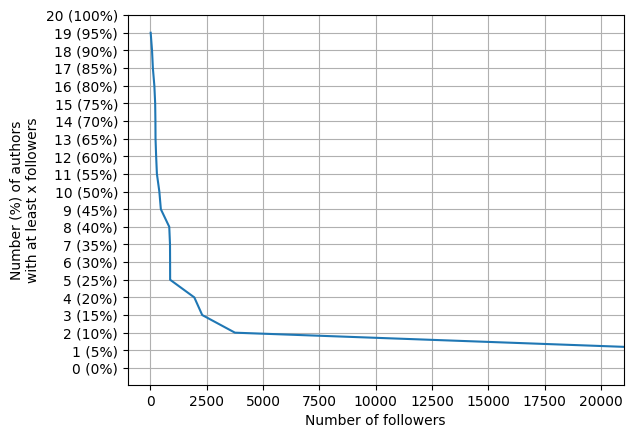

In [33]:
fig, ax = plt.subplots()

ecdf = ECDF(authors["follower_number"])
ax.plot(ecdf.x, 1-ecdf.y)
ax.grid()
ax.set_yticks(np.arange(0, 1.01, .05), [f"{int(round(y * len(authors),0)):,.0f} ({y:.0%})" for y in np.arange(0, 1.01, .05)])
ax.set_xlim(-1_000, 21_000)
ax.set_xlabel("Number of followers")
ax.set_ylabel("Number (%) of authors\nwith at least x followers");

In [34]:
authors[["follower_number", "pagerank_score"]].corr()

,follower_number,pagerank_score
follower_number,1.000000,0.843556
pagerank_score,0.843556,1.000000


ValueError: data must be finite, check for nan or inf values

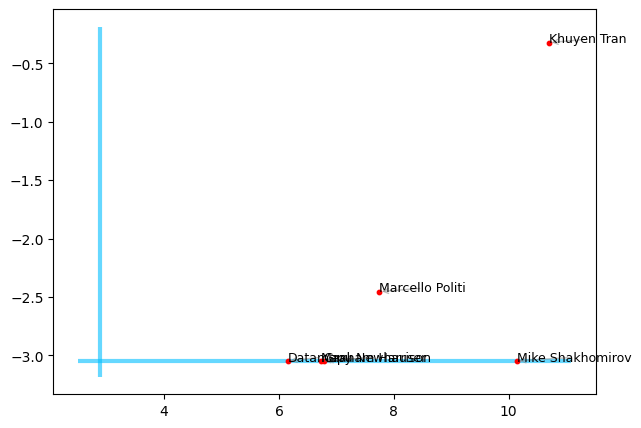

In [35]:
fig, ax = plt.subplots(figsize=(7,5))

top_20_followers = authors.sort_values("follower_number", ascending=False).head(20).index
top_20_pagerank = authors.sort_values("pagerank_score", ascending=False).head(20).index
ix = list(set(top_20_followers).union(top_20_pagerank))

authors["follower_number_log"] = np.log(authors["follower_number"])
authors["pagerank_score_log"] = np.log(authors["pagerank_score"])

minmax_x = authors.loc[ix,"follower_number_log"].describe()[["min","max"]]
minmax_y = authors.loc[ix,"pagerank_score_log"].describe()[["min","max"]]
minmax_x = np.array([minmax_x["min"] - (minmax_x["max"] - minmax_x["min"]) * .05, minmax_x["max"] + (minmax_x["max"] - minmax_x["min"]) * .05])
minmax_y = np.array([minmax_y["min"] - (minmax_y["max"] - minmax_y["min"]) * .05, minmax_y["max"] + (minmax_y["max"] - minmax_y["min"]) * .05])
minmax_x_revlog = np.exp(minmax_x)

ax.scatter(authors.loc[ix, "follower_number_log"], authors.loc[ix, "pagerank_score_log"], s=10, color="red", zorder=2)
ax.vlines(np.log(authors.loc[top_20_followers, "follower_number"].min()), minmax_y[0], minmax_y[1], color="deepskyblue", lw=3, alpha=.6, zorder=1)
ax.hlines(np.log(authors.loc[top_20_pagerank, "pagerank_score"].min()), minmax_x[0], minmax_x[1], color="deepskyblue", lw=3, alpha=.6, zorder=1)

emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "]+", flags=re.UNICODE)
texts = []
for i in ix:
    author_name = emoji_pattern.sub(r'', authors.loc[i,"author_name"]) # no emoji
    texts.append(
        ax.annotate(
            author_name,
            (authors.loc[i,"follower_number_log"], authors.loc[i,"pagerank_score_log"]),
            fontsize=9,
            arrowprops=dict(arrowstyle='->', color='grey', alpha=.5)))
adjust_text(texts)

xticks_unlog = np.array([2_500, 5_000, 10_000, 20_000, 40_000, 80_000, 160_000])
yticks_unlog = np.array([.0005, .001, .002, .004, .008, .016, .032])
xticks = np.log(xticks_unlog)
yticks = np.log(yticks_unlog)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{x:,.0f}" for x in xticks_unlog])
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y:.2%}" for y in yticks_unlog])
ax.set_ylabel("Influence\n(PageRank score among\nTowards Data Science writers)")
ax.set_xlabel("Popularity\n(number of Medium followers)")
ax.set_xlim(minmax_x)
ax.set_ylim(minmax_y)

fig.savefig("image.png", dpi=200, bbox_inches="tight")

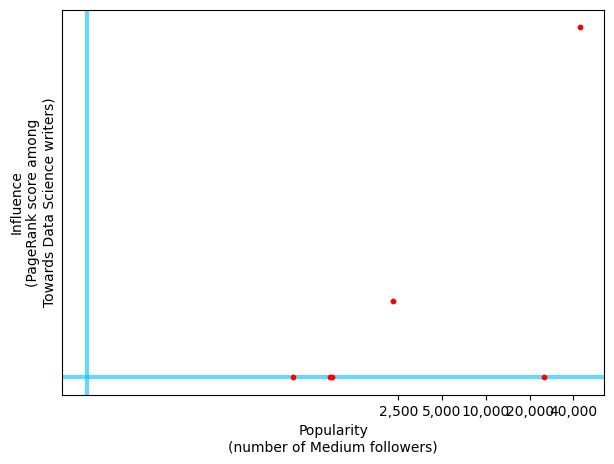

In [36]:
fig, ax = plt.subplots(figsize=(7,5))

top_20_followers = authors.sort_values("follower_number", ascending=False).head(20).index
top_20_pagerank = authors.sort_values("pagerank_score", ascending=False).head(20).index
ix = list(set(top_20_followers).union(top_20_pagerank))

authors["follower_number_log"] = np.log(authors["follower_number"])
authors["pagerank_score_log"] = np.log(authors["pagerank_score"])

minmax_x = authors.loc[ix,"follower_number_log"].describe()[["min","max"]]
minmax_y = authors.loc[ix,"pagerank_score_log"].describe()[["min","max"]]
minmax_x = np.array([minmax_x["min"] - (minmax_x["max"] - minmax_x["min"]) * .05, minmax_x["max"] + (minmax_x["max"] - minmax_x["min"]) * .05])
minmax_y = np.array([minmax_y["min"] - (minmax_y["max"] - minmax_y["min"]) * .05, minmax_y["max"] + (minmax_y["max"] - minmax_y["min"]) * .05])
minmax_x_revlog = np.exp(minmax_x)

ax.scatter(authors.loc[:, "follower_number_log"], authors.loc[:, "pagerank_score_log"], s=10, color="red", zorder=2)
ax.vlines(np.log(authors.loc[top_20_followers, "follower_number"].min()), minmax_y[0], minmax_y[1], color="deepskyblue", lw=3, alpha=.6, zorder=1)
ax.hlines(np.log(authors.loc[top_20_pagerank, "pagerank_score"].min()), minmax_x[0], minmax_x[1], color="deepskyblue", lw=3, alpha=.6, zorder=1)

xticks_unlog = np.array([2_500, 5_000, 10_000, 20_000, 40_000, 80_000, 160_000])
yticks_unlog = np.array([.0005, .001, .002, .004, .008, .016, .032])
xticks = np.log(xticks_unlog)
yticks = np.log(yticks_unlog)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{x:,.0f}" for x in xticks_unlog])
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y:.2%}" for y in yticks_unlog])
ax.set_ylabel("Influence\n(PageRank score among\nTowards Data Science writers)")
ax.set_xlabel("Popularity\n(number of Medium followers)")
ax.set_xlim(minmax_x)
ax.set_ylim(minmax_y)

fig.savefig("image_no_text.png", dpi=200, bbox_inches="tight")

In [37]:
authors.loc[top_20_followers, "author_name"]

,author_name
author_username,
khuyentran1476,Khuyen Tran
mshakhomirov,💡Mike Shakhomirov
mgalkin,Michael Galkin
marcellopoliti,Marcello Politi
ydong029,Yu Dong
grahamharrison-86487,Graham Harrison
donatoriccio,Donato Riccio
jyesr,Jye Sawtell-Rickson
mary.newhauser,Mary Newhauser


In [38]:
authors.loc[top_20_pagerank, "author_name"]

,author_name
author_username,
khuyentran1476,Khuyen Tran
marcellopoliti,Marcello Politi
grahamharrison-86487,Graham Harrison
mary.newhauser,Mary Newhauser
mshakhomirov,💡Mike Shakhomirov
pumaline,Datamapu
JavierMtz5,Javier Martínez Ojeda
donatoriccio,Donato Riccio
georgiadeaconu,Georgia Deaconu
